<a href="https://colab.research.google.com/github/Sazim2019331087/voice_model/blob/main/RNN_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================================
# --- GOOGLE COLAB SCRIPT FOR SPEAKER IDENTIFICATION (PERSON DETECTION) ---
# --- (Training an RNN Only Model from Scratch using MFCC Features) ---
# ==============================================================================

# --- IMPORTANT WARNING ---
print("="*80)
print("WARNING: Training a deep learning model from scratch (RNN Only)")
print("         with only 147 audio files is highly challenging and prone to overfitting.")
print("         The model will likely have limited generalization to new voices not in your dataset.")
print("         This code is provided for educational purposes to demonstrate the architecture.")
print("         Ensure you have a GPU runtime enabled in Colab, as CPU training will be extremely slow.")
print("="*80)

         with only 147 audio files is highly challenging and prone to overfitting.
         The model will likely have limited generalization to new voices not in your dataset.
         This code is provided for educational purposes to demonstrate the architecture.
         Ensure you have a GPU runtime enabled in Colab, as CPU training will be extremely slow.


In [2]:
# ==============================================================================
# Step 1: Setup and Install Libraries
# ==============================================================================
print("--- Installing required libraries ---")
!pip install --upgrade pip
# CRITICAL: Re-install PyTorch and TorchAudio to ensure CUDA version compatibility
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
!pip install pandas scikit-learn joblib tqdm
!pip install ffmpeg-python
!apt-get update && !apt-get install -y ffmpeg


--- Installing required libraries ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 134.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 66.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lit' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or 

In [3]:
# ==============================================================================
# Step 2: Mount Google Drive and Load Data
# ==============================================================================
from google.colab import drive
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchaudio
from torchaudio.transforms import MFCC
import numpy as np
from tqdm.notebook import tqdm
import joblib

print("\n--- Mounting Google Drive ---")
drive.mount('/content/drive')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package


--- Mounting Google Drive ---
Mounted at /content/drive


In [ ]:
# Load data from mounted drive
PROJECT_ROOT_DIR = '/content/drive/MyDrive/project'
CSV_PATH = os.path.join(PROJECT_ROOT_DIR, 'training.csv')
AUDIO_FOLDER_PATH = os.path.join(PROJECT_ROOT_DIR, 'voices')

if not os.path.exists(PROJECT_ROOT_DIR):
    raise FileNotFoundError(f"Error: Project folder '{PROJECT_ROOT_DIR}' not found. Please check the path and your Google Drive structure.")
elif not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Error: CSV file '{CSV_PATH}' not found. Please ensure it's in the correct location.")
elif not os.path.exists(AUDIO_FOLDER_PATH):
    raise FileNotFoundError(f"Error: Audio folder '{AUDIO_FOLDER_PATH}' not found. Please check the path and upload your audio files.")
else:
    print(f"Successfully located project folder at: {PROJECT_ROOT_DIR}")

print("\n--- Loading data from CSV ---")
df = pd.read_csv(CSV_PATH)
df['audio_path'] = df['audio_file'].apply(lambda x: os.path.join(AUDIO_FOLDER_PATH, x))

print("\n--- Verifying audio file paths and formats... ---")
verified_data_for_df = []

test_mfcc_transform = MFCC(
    sample_rate=16000, n_mfcc=40, melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 128}
)

problematic_files = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Verifying audio files"):
    audio_file_path = row['audio_path']

    if not os.path.exists(audio_file_path):
        problematic_files.append((row['audio_file'], row['email'], "File Not Found"))
        continue

    try:
        waveform, sample_rate = torchaudio.load(audio_file_path, frame_offset=0, num_frames=16000 * 2)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        elif waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)

        temp_mfcc_features = test_mfcc_transform(waveform)

        if temp_mfcc_features.ndim != 3 or temp_mfcc_features.shape[0] != 1:
            raise ValueError(f"Initial MFCC features for {audio_file_path} unexpected shape: {temp_mfcc_features.shape}")

        verified_data_for_df.append(row.to_dict())

    except Exception as e:
        problematic_files.append((row['audio_file'], speaker_id_raw, f"Format Error: {e}"))

if problematic_files:
    print(f"\n--- {len(problematic_files)} Problematic audio files found and skipped ---")
    problematic_df = pd.DataFrame(problematic_files, columns=['audio_file', 'email', 'Reason'])
    print(problematic_df.to_markdown(index=False, numalign="left", stralign="left"))
    print("\nTip: Use `ffmpeg -i input.wav -ar 16000 -ac 1 -c:a pcm_s16le output_converted.wav` to convert problematic files.")
else:
    print("\nAll audio files verified successfully!")

if not verified_data_for_df:
    raise ValueError("No valid audio files found after verification. Please check your data.")

existing_files_df = pd.DataFrame(verified_data_for_df)
existing_files_df['speaker_id'] = existing_files_df['email'].astype('category').cat.codes
speaker_mapping = dict(enumerate(existing_files_df['email'].astype('category').cat.categories))
num_speakers = len(speaker_mapping)

print(f"\n--- Speaker Mapping (Total Unique Speakers: {num_speakers}) ---")
print(speaker_mapping)

if len(existing_files_df) < num_speakers * 2:
    print("\nWARNING: Dataset has very few samples per speaker. Stratification might be difficult.")
    print(f"Total samples: {len(existing_files_df)}, Unique speakers: {num_speakers}")
    train_df, test_df = train_test_split(
        existing_files_df,
        test_size=max(1, min(int(0.2 * len(existing_files_df)), num_speakers)),
        random_state=42,
        stratify=None
    )
    print("Proceeding with NON-STRATIFIED split due to limited samples per speaker.")
else:
    train_df, test_df = train_test_split(
        existing_files_df,
        test_size=num_speakers,
        random_state=42,
        stratify=existing_files_df['speaker_id']
    )
    print(f"Using STRATIFIED split with {len(test_df)} samples in test set.")

print(f"\n--- Dataset Split for Training and Testing ---\nTraining samples: {len(train_df)}\nTesting samples: {len(test_df)}")


In [5]:
# ==============================================================================
# Step 3: Create a Custom PyTorch Dataset with MFCCs
# ==============================================================================
class SpeakerDatasetMFCC(Dataset):
    def __init__(self, dataframe, target_sr=16000, num_mfcc=40, n_fft=400, hop_length=160):
        self.dataframe = dataframe
        self.target_sr = target_sr
        self.num_mfcc = num_mfcc
        self.max_len_sec = 30
        self.max_len_samples = self.max_len_sec * self.target_sr

        self.mfcc_transform = MFCC(
            sample_rate=target_sr, n_mfcc=num_mfcc, melkwargs={'n_fft': n_fft, 'hop_length': hop_length, 'n_mels': 128}
        )

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['audio_path']
        label = row['speaker_id']

        try:
            waveform, sample_rate = torchaudio.load(audio_path)

            if sample_rate != self.target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sr)
                waveform = resampler(waveform)

            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            elif waveform.ndim == 1:
                waveform = waveform.unsqueeze(0)

            if waveform.shape[1] > self.max_len_samples:
                waveform = waveform[:, :self.max_len_samples]
            elif waveform.shape[1] < self.max_len_samples:
                padding = self.max_len_samples - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))

            mfcc_features = self.mfcc_transform(waveform)

            if mfcc_features.ndim == 3 and mfcc_features.shape[0] == 1:
                mfcc_features = mfcc_features.squeeze(0)

            return mfcc_features, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error processing {audio_path}: {e}. Skipping this sample.")
            return None, None

def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]
    if not batch:
        return None, None

    mfccs, labels = zip(*batch)

    mfccs_stacked = torch.stack(mfccs)
    labels_stacked = torch.stack(labels)

    return mfccs_stacked, labels_stacked

train_dataset = SpeakerDatasetMFCC(train_df)
test_dataset = SpeakerDatasetMFCC(test_df)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f"\n--- DataLoader created. Total training batches: {len(train_loader)} ---")


--- DataLoader created. Total training batches: 24 ---


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [6]:
# ==============================================================================
# Step 4: Define an RNN Model (SpeakerRNN)
# ==============================================================================

class SpeakerRNN(nn.Module):
    def __init__(self, num_speakers, num_mfcc=40, hidden_dim=128, rnn_layers=2, dropout_rate=0.3):
        super(SpeakerRNN, self).__init__()

        print("\n--- Initializing SpeakerRNN Model Architecture (ONLY RNN) ---")
        print(f"Number of speakers (output classes): {num_speakers}")
        print(f"Number of MFCC features (input features for RNN): {num_mfcc}")
        print(f"RNN hidden dimension: {hidden_dim}")
        print(f"Number of RNN layers: {rnn_layers}")
        print(f"Dropout rate: {dropout_rate}")

        # RNN (GRU) layers for temporal modeling
        # Input to RNN: (batch_size, sequence_length_frames, num_mfcc)
        self.rnn = nn.GRU(
            input_size=num_mfcc, # RNN input size is directly the number of MFCC features
            hidden_size=hidden_dim,
            num_layers=rnn_layers,
            bidirectional=True,
            batch_first=True
        )
        print(f"  RNN Layer: GRU(input={num_mfcc}, hidden={hidden_dim}, layers={rnn_layers}, bidirectional=True)")

        # Global Average Pooling after RNN to get a fixed-size embedding for classification
        # Output of RNN is (batch_size, sequence_length, hidden_dim * 2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        print(f"  Global Pooling Layer: AdaptiveAvgPool1d(1) (summarizes RNN output sequence)")

        # Final fully connected layer for classification
        self.fc_layer = nn.Linear(hidden_dim * 2, num_speakers) # hidden_dim * 2 for bidirectional
        print(f"  Fully Connected Layer: Linear(in={hidden_dim * 2}, out={num_speakers})")
        self.dropout = nn.Dropout(dropout_rate)
        print(f"  Dropout Layer: Dropout(p={dropout_rate})")
        print("--- Model Initialization Complete ---")

    def forward(self, x):
        # x shape: (batch_size, num_mfcc, sequence_length_frames)
        # For RNN, input needs to be (batch_size, sequence_length_frames, num_mfcc)

        # Permute MFCCs for RNN input
        x = x.permute(0, 2, 1) # Output shape: (batch_size, sequence_length_frames, num_mfcc)

        # RNN layers
        rnn_out, _ = self.rnn(x) # rnn_out shape: (batch_size, sequence_length_frames, hidden_dim * 2)

        # Apply Global Average Pooling across the sequence length dimension (dim=1)
        pooled_output = self.global_pool(rnn_out.permute(0, 2, 1)).squeeze(-1) # Output: (batch_size, hidden_dim * 2)

        # Dropout for regularization
        x = self.dropout(pooled_output)

        # Final fully connected layer for classification
        x = self.fc_layer(x)

        return x

# Determine the device (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n--- Initializing model on device: {device} ---")

# Initialize the SpeakerRNN model
model = SpeakerRNN(num_speakers=num_speakers, num_mfcc=train_dataset.num_mfcc).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


--- Initializing model on device: cuda ---

--- Initializing SpeakerRNN Model Architecture (ONLY RNN) ---
Number of speakers (output classes): 52
Number of MFCC features (input features for RNN): 40
RNN hidden dimension: 128
Number of RNN layers: 2
Dropout rate: 0.3
  RNN Layer: GRU(input=40, hidden=128, layers=2, bidirectional=True)
  Global Pooling Layer: AdaptiveAvgPool1d(1) (summarizes RNN output sequence)
  Fully Connected Layer: Linear(in=256, out=52)
  Dropout Layer: Dropout(p=0.3)
--- Model Initialization Complete ---


In [ ]:
# ==============================================================================
# Step 5: Train the Model
# ==============================================================================

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):
    model.train()
    print("\n--- Starting Training ---")
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        for i, (inputs, labels) in enumerate(pbar):
            if inputs is None:
                pbar.set_postfix_str("Skipping empty batch")
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': running_loss / (i+1), 'train_acc': 100 * correct_train_predictions / total_train_samples})

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = 100 * correct_train_predictions / total_train_samples

        model.eval()
        correct_test_predictions = 0
        total_test_samples = 0
        test_loss = 0.0

        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Test)")
            for inputs, labels in test_pbar:
                if inputs is None: continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                correct_test_predictions += (predicted == labels).sum().item()
                test_pbar.set_postfix({'test_loss': test_loss / (test_pbar.n + 1), 'test_acc': 100 * correct_test_predictions / total_test_samples})

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_accuracy = 100 * correct_test_predictions / total_test_samples

        print(f"Epoch {epoch+1} Summary: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_accuracy:.2f}%")

        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            SAVE_DIR = os.path.join(PROJECT_ROOT_DIR, 'saved_models_rnn_only') # Changed save directory
            os.makedirs(SAVE_DIR, exist_ok=True)
            model_save_path = os.path.join(SAVE_DIR, 'speaker_rnn_best.pth') # Changed model name
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Test Accuracy: {best_accuracy:.2f}%")

        model.train()

train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)


In [9]:
# ==============================================================================
# Step 6: Save the Trained Model and Speaker Mapping (Final Save)
# ==============================================================================
SAVE_DIR = os.path.join(PROJECT_ROOT_DIR, 'saved_models_rnn_only') # Changed save directory
os.makedirs(SAVE_DIR, exist_ok=True)
model_final_save_path = os.path.join(SAVE_DIR, 'speaker_rnn_final.pth') # Changed model name
mapping_save_path = os.path.join(SAVE_DIR, 'speaker_mapping_rnn_only.joblib') # Changed mapping name

joblib.dump(speaker_mapping, mapping_save_path)
torch.save(model.state_dict(), model_final_save_path)

print(f"\n--- Final Trained Model Saved to: {model_final_save_path} ---")
print(f"Speaker Mapping Saved to: {mapping_save_path}")


--- Final Trained Model Saved to: /content/drive/MyDrive/project/saved_models_rnn_only/speaker_rnn_final.pth ---
Speaker Mapping Saved to: /content/drive/MyDrive/project/saved_models_rnn_only/speaker_mapping_rnn_only.joblib


In [11]:
# ==============================================================================
# Step 7: Inference (Detect a Person from a New Audio File - Interactive Upload)
# ==============================================================================
from google.colab import files
import soundfile as sf

def predict_speaker_from_audio(model, audio_file_path, speaker_mapping,
                               target_sr=16000, num_mfcc=40, n_fft=400, hop_length=160):
    model.eval()
    mfcc_transform = MFCC(sample_rate=target_sr, n_mfcc=num_mfcc, melkwargs={'n_fft': n_fft, 'hop_length': hop_length})
    max_len_samples = 30 * target_sr

    try:
        if not os.path.exists(audio_file_path):
            raise FileNotFoundError(f"Audio file not found: {audio_file_path}")

        waveform, sample_rate = torchaudio.load(audio_file_path)
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            waveform = resampler(waveform)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        elif waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)

        if waveform.shape[1] > max_len_samples:
            waveform = waveform[:, :max_len_samples]
        elif waveform.shape[1] < max_len_samples:
            padding = max_len_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        mfcc_features = mfcc_transform(waveform)

        if mfcc_features.ndim == 3 and mfcc_features.shape[0] == 1:
            mfcc_features = mfcc_features.squeeze(0)

        input_tensor = mfcc_features.unsqueeze(0).to(next(model.parameters()).device)

        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_id_tensor = torch.max(probabilities, 1)

            predicted_id = predicted_id_tensor.item()
            predicted_confidence = confidence.item()

        predicted_email = speaker_mapping[predicted_id]

        return predicted_email, predicted_confidence

    except Exception as e:
        print(f"Error during inference for {audio_file_path}: {e}")
        return None, None

# Reload the best saved model and mapping for inference
loaded_model = SpeakerRNN(num_speakers=num_speakers, num_mfcc=train_dataset.num_mfcc).to(device) # Changed model class
best_model_path = os.path.join(PROJECT_ROOT_DIR, 'saved_models_rnn_only', 'speaker_rnn_best.pth') # Changed path/name
model_final_save_path = os.path.join(PROJECT_ROOT_DIR, 'saved_models_rnn_only', 'speaker_rnn_final.pth') # Changed path/name

if os.path.exists(best_model_path):
    loaded_model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from: {best_model_path}")
else:
    loaded_model.load_state_dict(torch.load(model_final_save_path, map_location=device))
    print(f"Loaded final model from: {model_final_save_path} (Best model not found)")

loaded_speaker_mapping = joblib.load(os.path.join(PROJECT_ROOT_DIR, 'saved_models_rnn_only', 'speaker_mapping_rnn_only.joblib')) # Changed mapping name

# Load existing_files_df to get names
try:
    full_df = pd.read_csv(CSV_PATH)
    full_df['audio_path'] = full_df['audio_ffile'].apply(lambda x: os.path.join(AUDIO_FOLDER_PATH, x))
    existing_files_df_temp = full_df[full_df['audio_path'].apply(os.path.exists)].copy().reset_index(drop=True)
    existing_files_df_temp['speaker_id'] = existing_files_df_temp['email'].astype('category').cat.codes
    existing_files_df = existing_files_df_temp
    print("Reloaded existing_files_df for name lookup.")
except Exception as e:
    print(f"Error reloading existing_files_df for name lookup: {e}")
    existing_files_df = pd.DataFrame({'email': [], 'name': []})


print("\n--- Upload an audio file from your PC for speaker detection ---")
uploaded_files = files.upload()

if uploaded_files:
    uploaded_file_name = list(uploaded_files.keys())[0]
    uploaded_file_path = os.path.join('/content/', uploaded_file_name)

    print(f"\nUploaded file: {uploaded_file_name}")
    print(f"File saved to: {uploaded_file_path}")

    print(f"\n--- Performing Inference on the uploaded audio file ---")

    detected_email, confidence = predict_speaker_from_audio(
        loaded_model, uploaded_file_path, loaded_speaker_mapping,
        num_mfcc=train_dataset.num_mfcc
    )

    if detected_email:
        print("\n--- Detection Result ---")
        print(f"Corresponding Email ID: {detected_email}")
        print(f"Confidence: {confidence:.4f}")

    else:
        print("Detection failed for the uploaded file. No matching speaker found or an error occurred.")
        print("Ensure it's a clear recording of one of the trained speakers.")
        print(f"Best confidence achieved (if any): {confidence:.4f}")

else:
    print("No file was uploaded.")



--- Initializing SpeakerRNN Model Architecture (ONLY RNN) ---
Number of speakers (output classes): 52
Number of MFCC features (input features for RNN): 40
RNN hidden dimension: 128
Number of RNN layers: 2
Dropout rate: 0.3
  RNN Layer: GRU(input=40, hidden=128, layers=2, bidirectional=True)
  Global Pooling Layer: AdaptiveAvgPool1d(1) (summarizes RNN output sequence)
  Fully Connected Layer: Linear(in=256, out=52)
  Dropout Layer: Dropout(p=0.3)
--- Model Initialization Complete ---
Loaded best model from: /content/drive/MyDrive/project/saved_models_rnn_only/speaker_rnn_best.pth
Error reloading existing_files_df for name lookup: 'audio_ffile'

--- Upload an audio file from your PC for speaker detection ---


Saving 6853a9488a9d3.wav to 6853a9488a9d3.wav

Uploaded file: 6853a9488a9d3.wav
File saved to: /content/6853a9488a9d3.wav

--- Performing Inference on the uploaded audio file ---


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(



--- Detection Result ---
Corresponding Email ID: pappu251618@gmail.com
Confidence: 0.6240


In [13]:
pip install scikit-learn seaborn tqdm matplotlib numpy

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Containers for ground truth and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())


# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [15]:
# ----------------------------
#  Compute Basic Metrics
# ----------------------------
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

In [16]:
# ----------------------------
#  Classification Report
# ----------------------------
print("\n=== Classification Report ===\n")
print(classification_report(all_labels, all_preds, digits=4))


=== Classification Report ===

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.0000    0.0000    0.0000         1
           2     1.0000    1.0000    1.0000         1
           3     1.0000    1.0000    1.0000         1
           4     1.0000    1.0000    1.0000         1
           5     1.0000    1.0000    1.0000         1
           6     0.5000    1.0000    0.6667         1
           7     1.0000    1.0000    1.0000         1
           8     0.0000    0.0000    0.0000         1
           9     1.0000    1.0000    1.0000         1
          10     1.0000    1.0000    1.0000         1
          11     1.0000    1.0000    1.0000         1
          12     0.5000    1.0000    0.6667         1
          13     0.3333    1.0000    0.5000         1
          14     0.0000    0.0000    0.0000         1
          15     1.0000    1.0000    1.0000         1
          16     0.0000    0.0000    0.0000      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


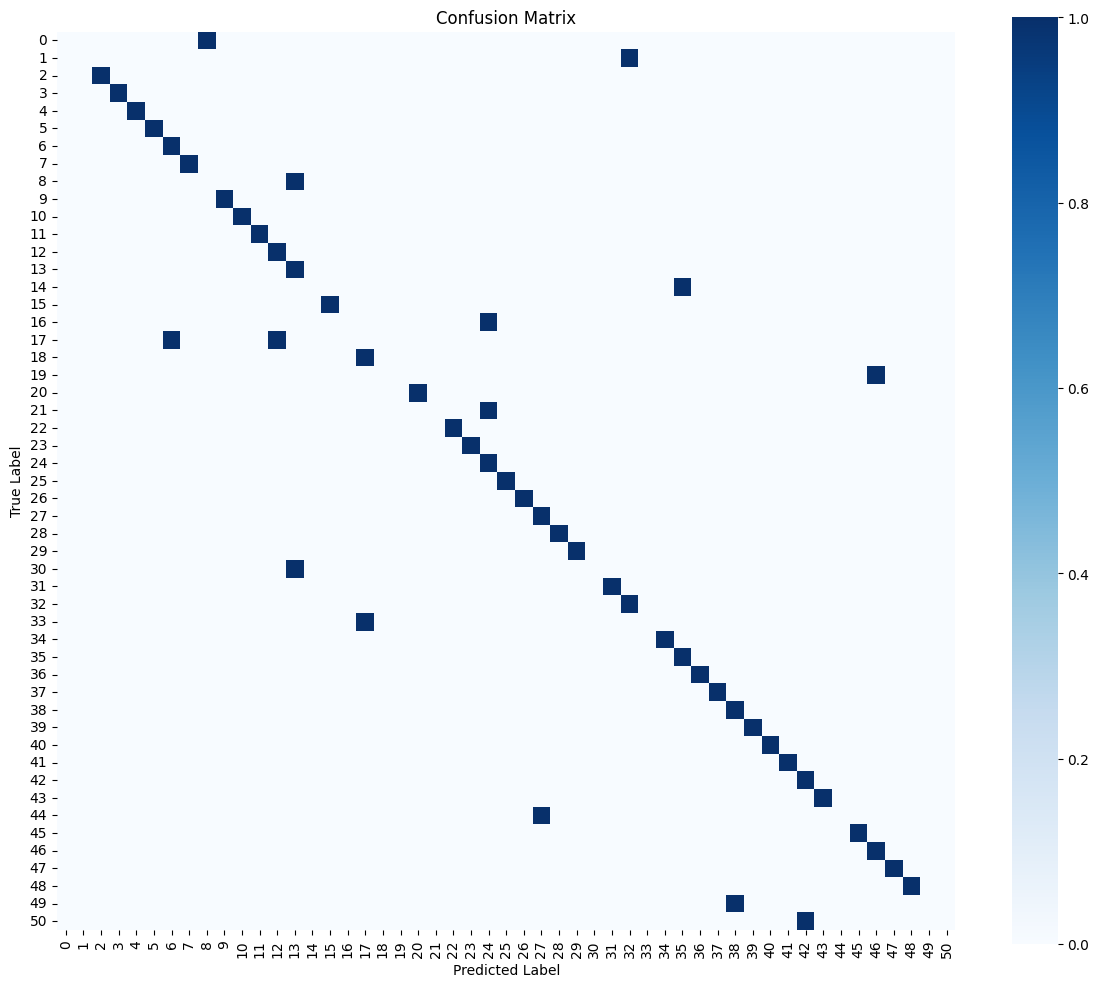

In [17]:
# ----------------------------
#  Confusion Matrix
# ----------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", fmt='d', square=True, cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [18]:
# ----------------------------
#  Summary of Metrics
# ----------------------------
print("\n=== Evaluation Summary ===")
print(f"Accuracy       : {accuracy * 100:.2f}%")
print(f"Precision (macro avg): {precision:.4f}")
print(f"Recall (macro avg)   : {recall:.4f}")
print(f"F1 Score (macro avg) : {f1:.4f}")


=== Evaluation Summary ===
Accuracy       : 71.15%
Precision (macro avg): 0.6209
Recall (macro avg)   : 0.7255
F1 Score (macro avg) : 0.6536


/tmp/ipython-input-19-1084863706.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


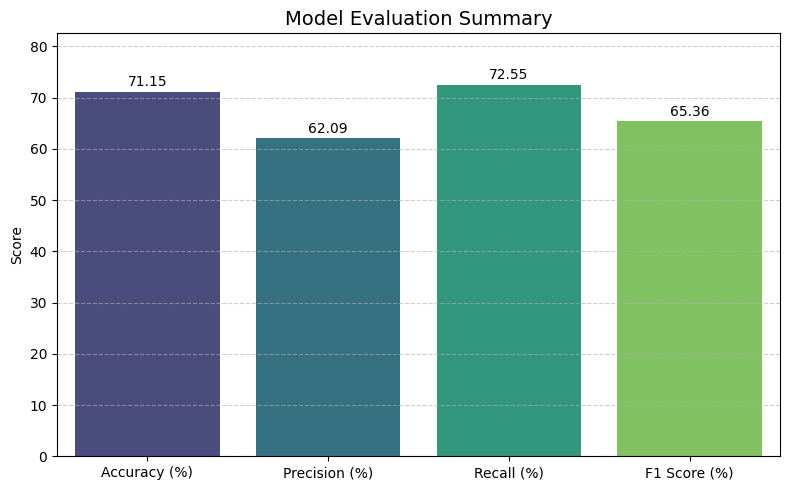

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# our computed metrics
accuracy_percent = accuracy * 100
metrics = {
    "Accuracy (%)": accuracy_percent,
    "Precision (%)": precision * 100,
    "Recall (%)": recall * 100,
    "F1 Score (%)": f1 * 100
}

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')

# Annotate bars with values
for i, (key, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.5, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Model Evaluation Summary", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, max(metrics.values()) + 10)  # Add margin for accuracy which is in percent
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()